# Visualización de Redes Convolucionales

In [1]:
import keras
keras.__version__

/opt/anaconda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


'2.1.6'

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1" 

# Visualizando el Aprendizaje de Redes Convolucionales

A menudo se dice que los modelos DL son *cajas negras* debido que las representaciones aprendidas son difíciles de interpretar por humanos, pero, aunque es cierto en la mayoría de los casos, vamos a ver que no es así para las Redes Convolucionales, donde el hecho de estar trabajando con información visual y basarse en la forma en que se agrupa jerárquicamente esta información, facilita enormemente poder dar una interpretación visual a lo que las diversas capas convolucionales han aprendido. 

Desde 2013 se han generado muchas técnicas para visualizar e interpretar estas representaciones e intentaremos cubrir algunas de las más representativas y accesibles. Concretamente, en este ejemplo vamos a ver cómo:

1. Visualizar las salidas de las capas intermedias (**activaciones intermedias**): útil para comprender cómo las sucesivas capas transformarn sus entradas y para tener una idea inicial de la funcionalidad que tienen los filtros convolucionales individuales.
2. Visualizar filtros convolucionales: útil para entender de forma precisa a qué patrones visuales (o conceptos) son sensibles los diversos filtros.
3. Visualizar **mapas de calor** de las clases de activación sobre muestras (imágenes): útil para entender qué partes de una imagen son identificadas como una clase específica de las reconocidas por la red, lo que, por ejemplo, puede servir además para localizar objetos reconocidos dentro de una imagen.

Para el primer método usaremos la pequeña red que entrenamos desde cero para recoocer gatos y perros. Para los otros dos métodos usaremos el modelo VGG16 que viene preentrenado y que ya hemos usado anteriormente.

## Visualizando Activaciones Intermedias

Visualizar las activaciones intermedias consiste en mostrar el mapa de características que conforman las salidas de las diferentes capas de convolución y pooling de la red para una determinada entrada (la salida de una capa a menudo se llama su **activación**, por ser la salida de su función de activación). 

Este procedimiento da una visión sobre cómo una entrada es descompuesta por las distintas capas aprendidas por la red, y no solo se puede hacer con Redes Convolucionales sino con cualquier tipo de capa, aunque sea en estas redes donde la interpretación visual es más directa. En este caso, los mapas de características tienen 3 dimensiones: anchura, altura y profundidad (canales). Cada canal codifica características relativamente independientes, por lo que la forma más apropiada de visualizar estas características es también representar independientemente los contenidos de cada canal como imágenes 2D. 

Para ponerlo en práctica, comencemos cargando el modelo que generamos en el módulo anterior:

In [3]:
from keras.models import load_model

model = load_model('cats_and_dogs_DA.h5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 15, 15, 128)       147584    
__________

Vamos a cargar una imagen de prueba (para que no haya correlación con el aprendizaje llevado a cabo, esta imagen será parte de nuestro conjunto de test, no de entrenamiento):


In [6]:
img_path = '../../data/cat_dogs/test/cats/cat.1820.jpg'

# Vamos a convertir la imagen en un tensor apropiado
from keras.preprocessing import image
import numpy as np

img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
# Recordemos que el modelo fue entrenado con entradas normaizadas:
img_tensor /= 255.

# La forma ahora es (1, 150, 150, 3)
print(img_tensor.shape)

(1, 150, 150, 3)


Usando la función adecuada de `matplotlib` podemos mostrarla:

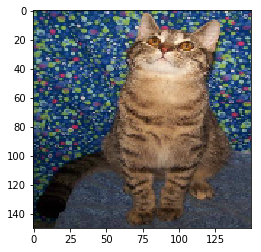

In [8]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(img_tensor[0])
plt.show()

Hemos de tener en cuenta que Keras solo trabaja con modelos, y la información que estamos buscando son las activaciones internas de un modelo ya definido, que el propio no proporciona externamente. Por ello, y con el fin de extraer los mapas de características, vamos a crear un modelo adicional de Keras que toma batches de imágenes como entrada y devuelve las activaciones de todas las capas de convolución y pooling del modelo anteriormente entrenado.

Para ello, usaremos la función `keras_model()`, que toma dos argumentos: un tensor de entrada (en realidad, una lista de tensores de entrada), y un tensor de salida (en realidad, una lista de tensores de salida). El resultado es un modelo de Keras, similar a los que ya hemos creado anteriormente por medio de `keras_sequential_model()` que lleva las entradas proporcionadas en las salidas. Lo que diferencia este tipo de modelos de los anteriores es que permite trabajar con múltiples salidas. Veremos más sobre este tipo de modelos más adelante.

In [9]:
from keras import models

# Extrae las salidas de las 8 capas superiores:
layer_outputs = [layer.output for layer in model.layers[:8]]
# Crea un modelo que devuelva estas salidas a partir de la entrada:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

Cuando a este modelo se le pasa una imagen de entrada, devuelve los valores de las activaciones de las 8 primeras capas del modelo original. 


In [10]:
activations = activation_model.predict(img_tensor)

Por ejemplo, la activación de la primera capa convolucional sobre nuestra imagen, sería:


In [11]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 148, 148, 32)


Un mapa de características de tamaño 148 x 148 con 32 canales. Visualicemos algunos de ellos por medio de las funciones de `matplotlib`:


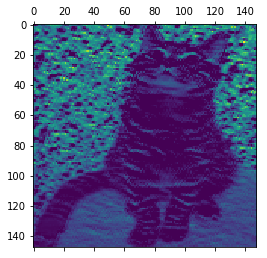

In [12]:
import matplotlib.pyplot as plt

plt.matshow(first_layer_activation[0, :, :, 3], cmap='viridis')
plt.show()

Por ejemplo, el 6º canal sería:


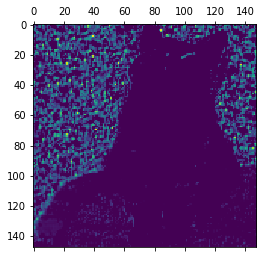

In [13]:
plt.matshow(first_layer_activation[0, :, :, 5], cmap='viridis')
plt.show()

Si modificas el valor del canal al que accedes podrás observar las diferencias existentes entre los fitros aprendidos en los diferentes canales.

Podemos mostrar una visualización completa de todas las activaciones de la red:


/opt/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide


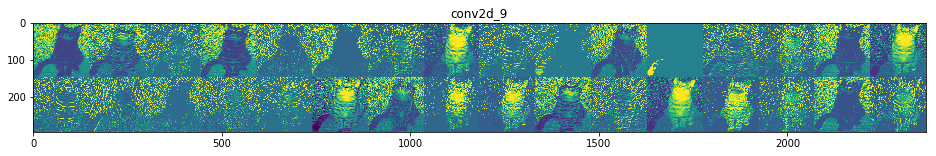

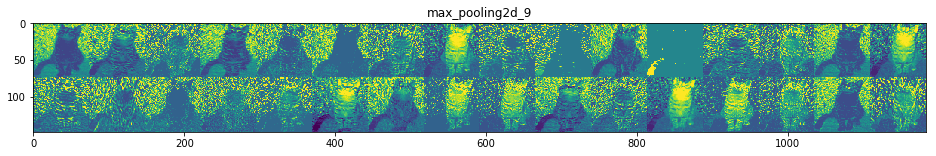

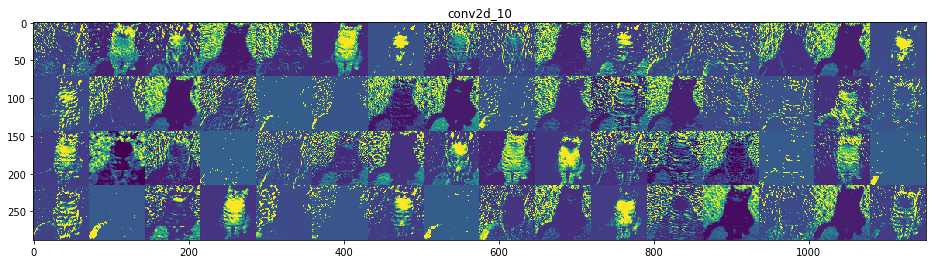

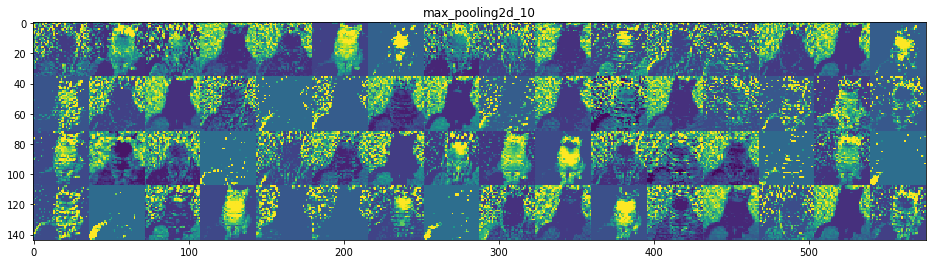

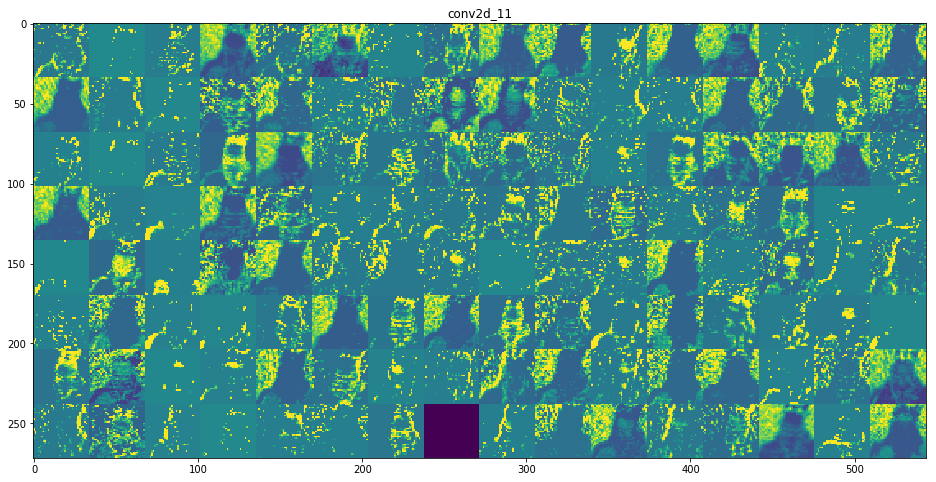

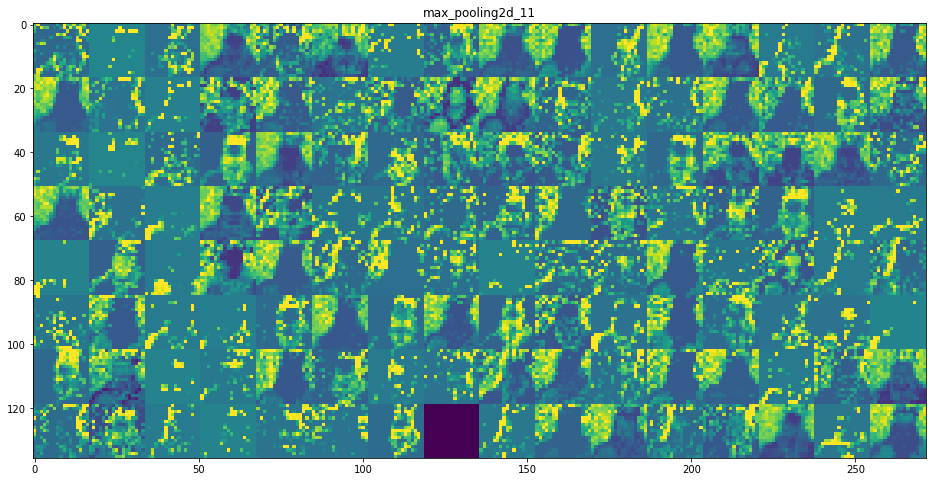

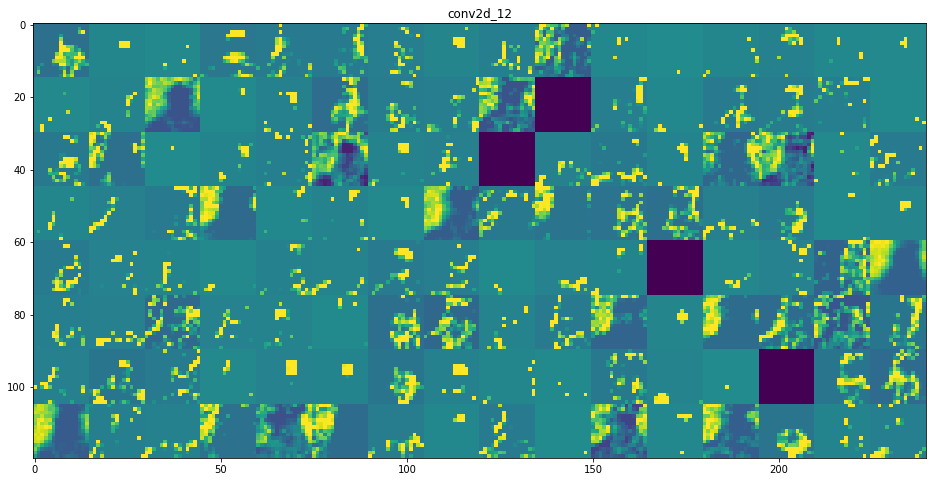

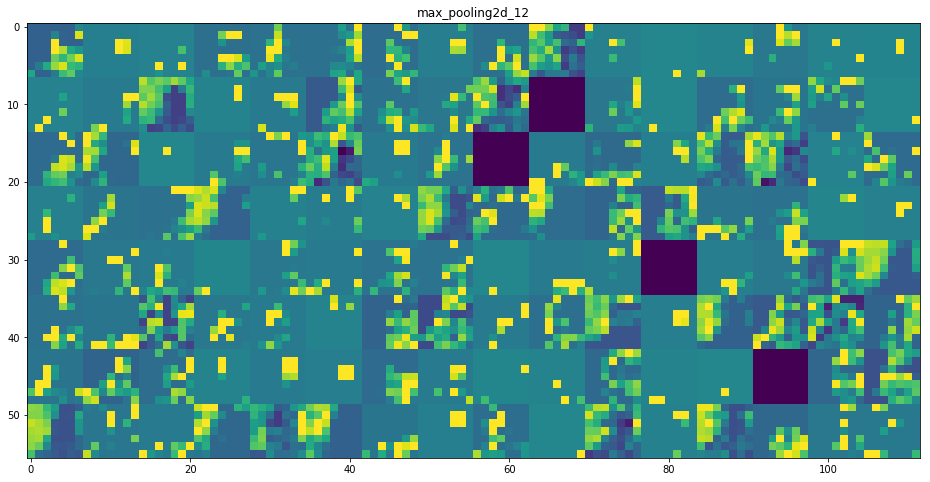

In [14]:
import keras

# These are the names of the layers, so can have them as part of our plot
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)

images_per_row = 16

# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, activations):

    # The feature map has shape (1, size, size, n_features)
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    
plt.show()

Alagunas cosas que debemos enfatizar:

* La primer capa actúa como una colección de detectores de bordes, y las activaciones prácticamente almacenan toda la información presente en la imagen incial.
* A medida que profundizamos en la red, las activaciones se van haciendo más abstractas y menos interpretables visualmente. Empiezan a codificar conceptos de mayor nivel y menos información visual, más relacionados con la clase a la que pertenece la imagen.
* Las activaciones se hacen más dispersas cuando la profundidad de la capa aumenta: en la primera capa todos los filtros se activan, pero en capas más profundas algunos filtros están en blanco. Esto significa que esos filtros codifican patrones que no están presentes en la imagen de entrada.

De esta forma, una red DL actúa efectivamente como un proceso de **destilación de información**, en el que la información relevante va perdiendo importancia para destacar los conceptos clave que determinan la clasificación. Es análogo a la forma en que los animales percibimos el mundo: tras unos segundos de observar una escena, recordamos información abstracta de los objetos que la componen, pero no podemos recordar detalles específicos de los mismos.

## Visualizando Filtros Convolucionales

Otra forma sencilla de inspeccionar los filtros que ha aprendido una Red Convolucional es mostrando los patrones visuales a los que cada filtro va a responder. Esto se puede hacer por medio de un truco similar a como se entrena la red, lo que se llama __gradiente descendiente en el espacio de entrada__, que consiste simplemente en encontrar la entrada que maximiza la respuesta del filtro.

El proceso es simple (teniendo las herramientas adecuadas): construimos una función de pérdida que maximiza el valor de un filtro determinado de una capa convolucional, comenzamos con una entrada cualquier (normalmente, en blanco o grises), y usamos un SGD para ajustar los valores de la imagen con el fin de maximizar sus valores de activación.

Vamos a trabajar ahora directamente con VGG16, y no con la red que entrenamos para nuestro problema de perros y gatos. Por ejemplo, el siguiente código muestra cómo definir una función de pérdida adecuada para el filtro 0 de la capa "block3_conv1" de la red VGG16 pre-entrenada con ImageNet:

In [15]:
from keras.applications import VGG16
from keras import backend as K

model = VGG16(weights='imagenet',
              include_top=False)

layer_name = 'block3_conv1'
filter_index = 0

layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:, :, :, filter_index])

Para implementar el descenso del gradiente necesitamos calcular el gradiente de la función de pérdida respecto a las entradas del modelo, para lo que usaremos la función de Keras `k_gradients`:

In [16]:
# The call to `gradients` returns a list of tensors (of size 1 in this case)
# hence we only keep the first element -- which is a tensor.
grads = K.gradients(loss, model.input)[0]

Con el fin de asegurar que la magnitud de las actualizaciones se mantengan en un rango adecuado, normalizaremos el gradiente (dividiéndolo por la norma L2 y sumando una pequeña cantidad fija para que no haya problemas de división por 0).


In [17]:
# We add 1e-5 before dividing so as to avoid accidentally dividing by 0.
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

Por medio de la función `k_function` de Keras (que instancia una función a partir de las entradas y salidas que debe tener) definimos una función `iterate` que permite calcular el valor del tensor de pérdida y el gradiente a partir de la imagen de entrada:


In [18]:
iterate = K.function([model.input], [loss, grads])

# Let's test it:
import numpy as np
loss_value, grads_value = iterate([np.zeros((1, 150, 150, 3))])

Una vez construido todo lo anterior, bastaría hacer un bucle para hacer el SGD de forma efectiva:


In [19]:
# We start from a gray image with some noise
input_img_data = np.random.random((1, 150, 150, 3)) * 20 + 128.

# Run gradient ascent for 40 steps
step = 1.  # this is the magnitude of each gradient update
for i in range(40):
    # Compute the loss value and gradient value
    loss_value, grads_value = iterate([input_img_data])
    # Here we adjust the input image in the direction that maximizes the loss
    input_img_data += grads_value * step

El resultado es un tensor de imagen (en valores flotantes) de tamaño `(1, 150, 150, 3)`, por lo que hemos de post-procesarlo para convertirlo en valores enteros en  [0, 255] y poder mostrarlo. Vamos a crear una función que haga precisamente eso:


In [20]:
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

Ahora que tenemos todas las piezas podemos ponerlas juntas en una sola función que toma como entrada el nombre de una capa y un índice de filtro, y devuelve un tensor de imagen que representa el patrón que maximiza la activación de ese filtro:


In [21]:
def generate_pattern(layer_name, filter_index, size=150):
    # Build a loss function that maximizes the activation
    # of the nth filter of the layer considered.
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])

    # Compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, model.input)[0]

    # Normalization trick: we normalize the gradient
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

    # This function returns the loss and grads given the input picture
    iterate = K.function([model.input], [loss, grads])
    
    # We start from a gray image with some noise
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.

    # Run gradient ascent for 40 steps
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        
    img = input_img_data[0]
    return deprocess_image(img)

Vamos a probarlo:


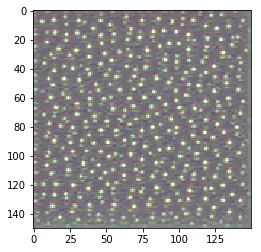

In [22]:
plt.imshow(generate_pattern('block3_conv1', 0))
plt.show()

Lo interesante es que podemos visualizar todos los fitros de cada capa. En el ejemplo siguiente se muestra cómo obtener una visualización de los 64 primeros filtros de cada capa convolucional de los primeros 4 bloques, y los mostramos como una malla de 8x8 patrones:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


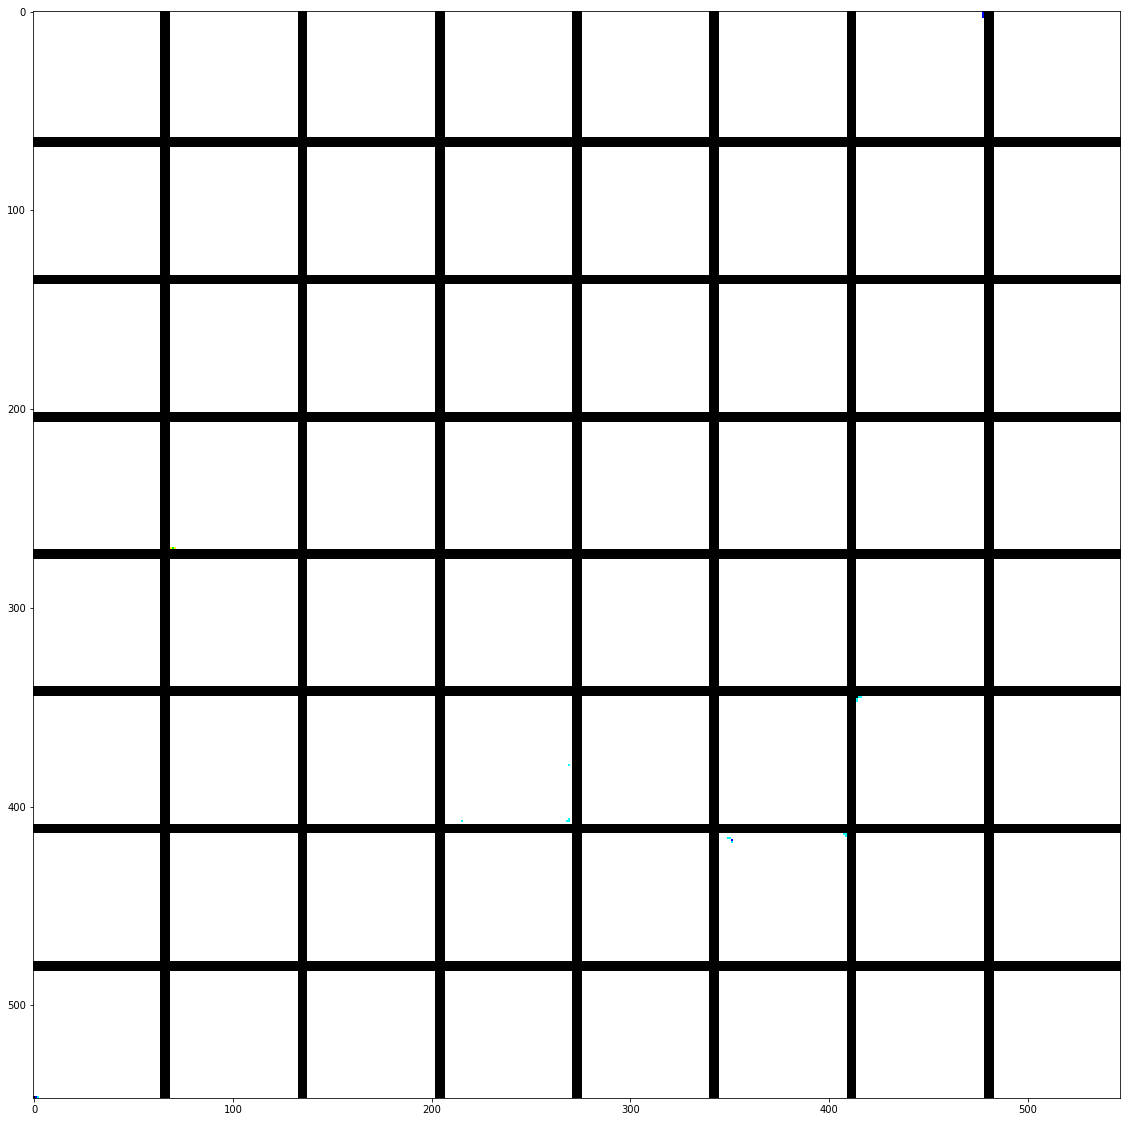

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


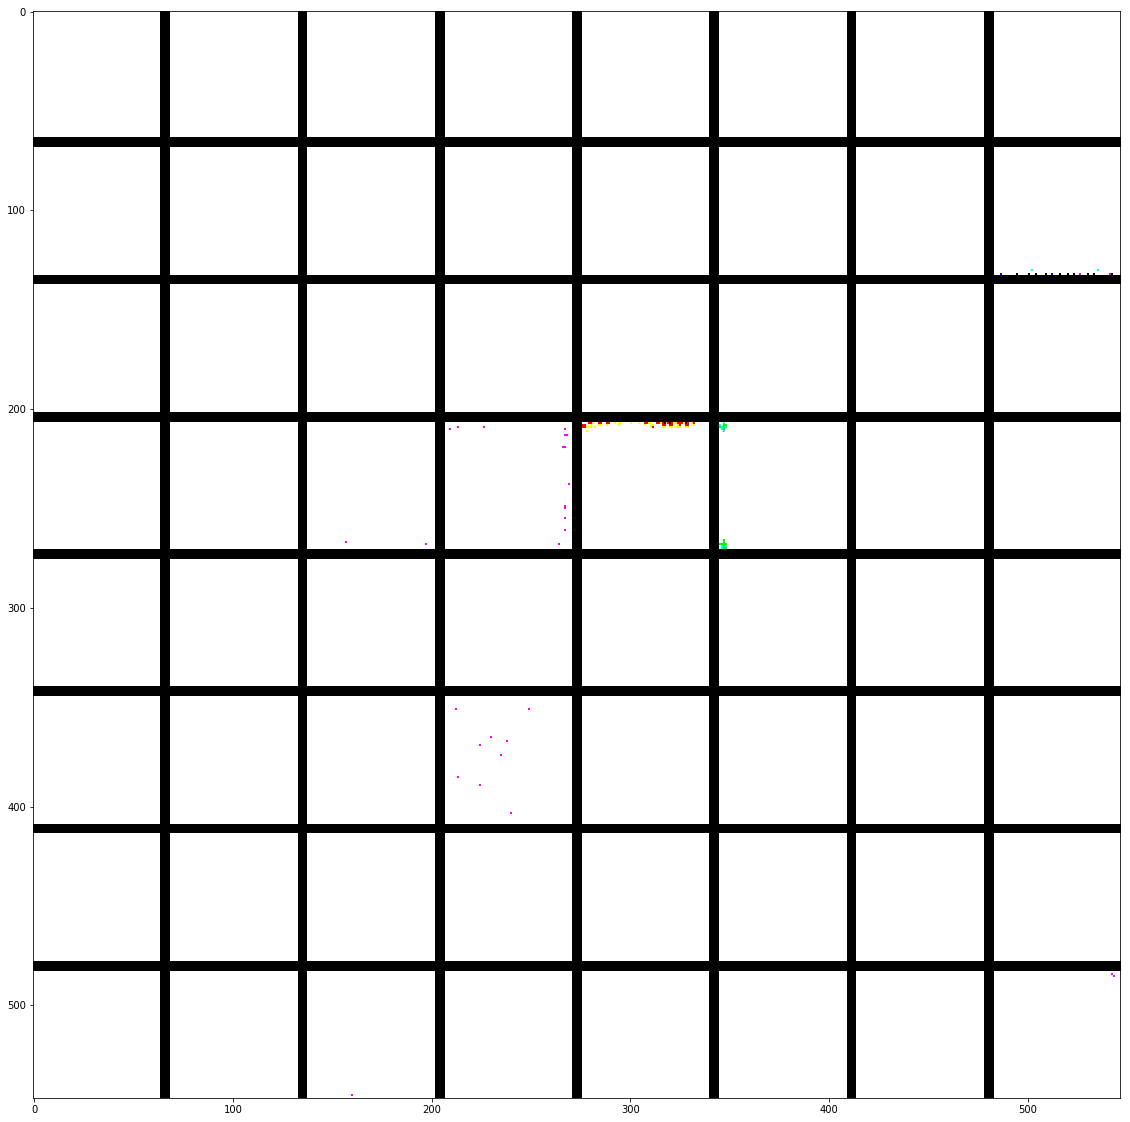

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


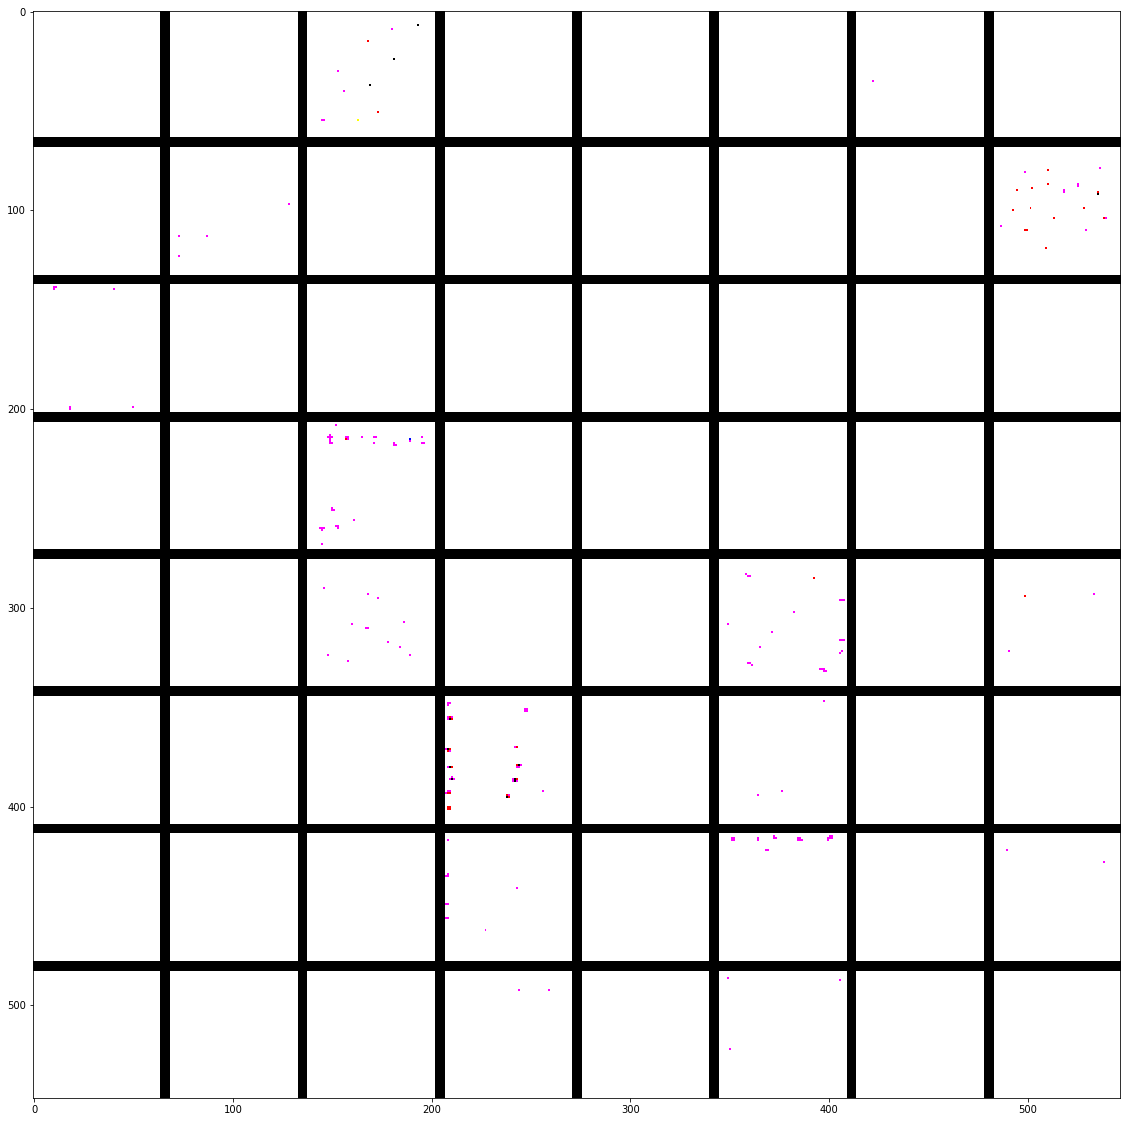

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


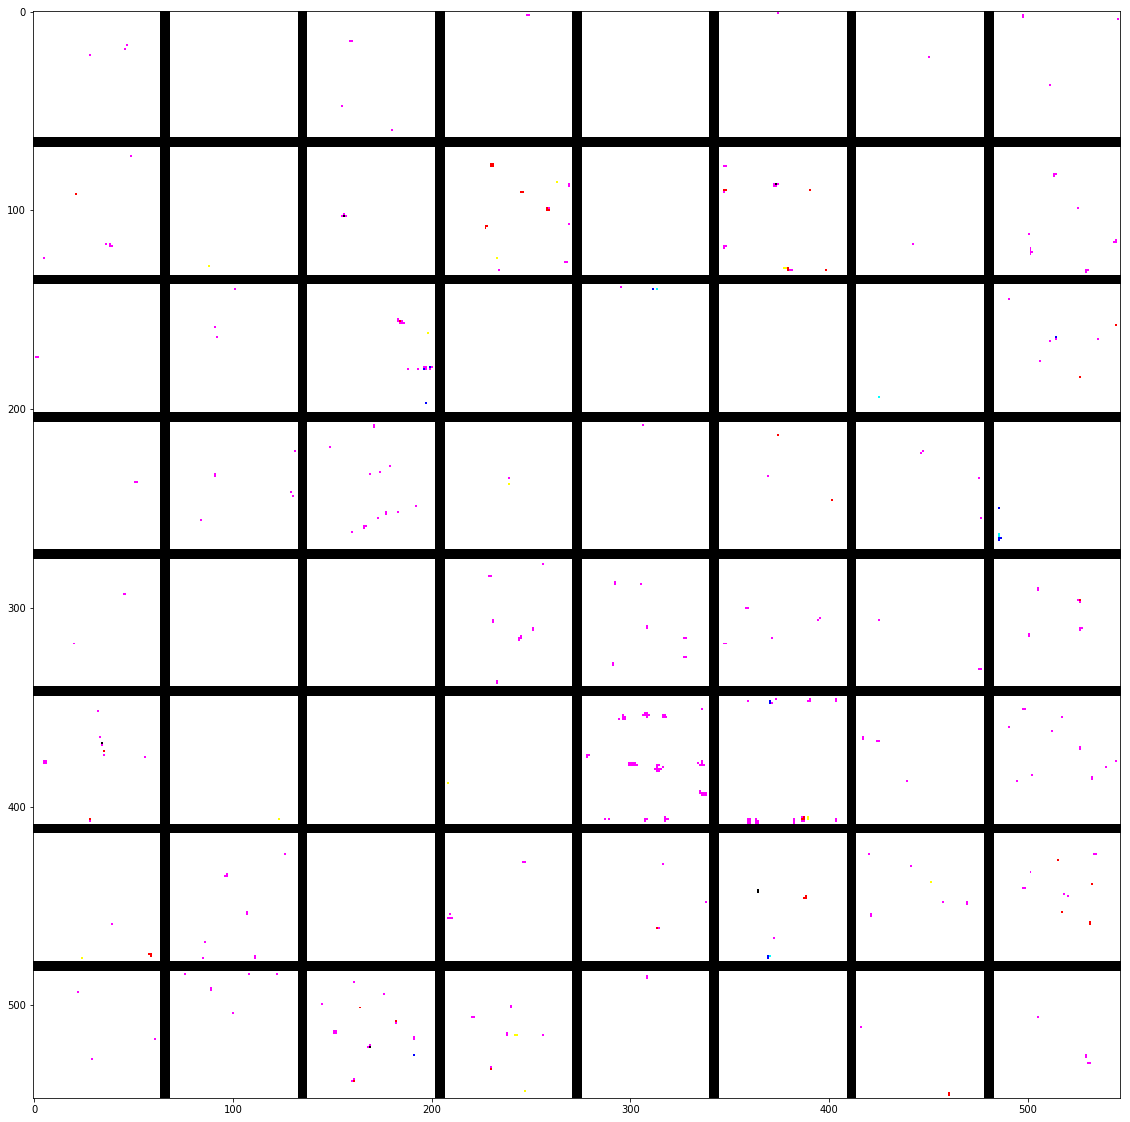

In [23]:
for layer_name in ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1']:
    size = 64
    margin = 5

    # This a empty (black) image where we will store our results.
    results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3))

    for i in range(8):  # iterate over the rows of our results grid
        for j in range(8):  # iterate over the columns of our results grid
            # Generate the pattern for filter `i + (j * 8)` in `layer_name`
            filter_img = generate_pattern(layer_name, i + (j * 8), size=size)

            # Put the result in the square `(i, j)` of the results grid
            horizontal_start = i * size + i * margin
            horizontal_end = horizontal_start + size
            vertical_start = j * size + j * margin
            vertical_end = vertical_start + size
            results[horizontal_start: horizontal_end, vertical_start: vertical_end, :] = filter_img

    # Display the results grid
    plt.figure(figsize=(20, 20))
    plt.imshow(results)
    plt.show()

Estas visualizaciones dan mucha información acerca de cómo las capas convolucionales ven el mundo, de forma similar a cómo la transformada de Fourier descompone las señales como una colección de funciones coseno. Observa cómo el patrón de los filtros se vuelve más complejo a medida que se profundiza en la red.

## Visualizando Mapas de Calor de las Activaciones de cada Clase

La técnica que introducimos ahora permite visualizar qué partes de una imagen llevan a la red a decidir su clasificación final, lo que puede ser interesante para ver qué errores concretos se producen en errores de clasificación y para especificar dónde están los objetos específicos que se clasifican en una escena.

El nombre general que se le da a esta categoría de técnicas es el de **Mapas de Activación de Clases** y consiste en producir sobre la imagen original un **mapa de calor**, que es una malla 2D con valores asociados a una clase específica indicando la importancia de los pixels que hay debajo para que la clasificación sea esa.

Seguiremos la implementación descrita en ["Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization." Ramprasaath R. Selvaraju et al., Cornell University Library, March 21, 2017](https://arxiv.org/abs/1610.02391).

La idea es muy simple, consiste en tomar el mapa de cartacerísticas de una capa convolucional que produce una imagen de entrada y ponderar cada canal del mapa con el gradiente de la clase con respecto a ese canal. Intuitivamente, lo que se realiza es una poderación de *"cómo activa la imagen de entrada a los diferentes canales"* con *"cómo de importante es ese canal para la clase resultante"*, obteniendo *"cuánto activa la imagen de entrada la clase"*.

De nuevo, vamos a probar esta técnica usando la red VGG16 preentrenada.

In [ ]:
from keras.applications.vgg16 import VGG16

K.clear_session()

# Observa que ahora sí incluimos la última capa densa clasificadora;
# en todos los casos previos la descartamos.
model = VGG16(weights='imagenet')

123879424/553467096 [=====>........................] - ETA: 3:21:27

Vamos a considerar como muestra la siguiente imagen de dos elefantes africanos (que tiene licencia Creative Commons):

![elephants](creative_commons_elephant.jpg)

El primer paso es convertirla a algo que el modelo VGG16 pueda leer. El modelo fue entrenado con imágenes de tamaño 224x244, preprocesadas de acuerdo a las reglas que vienen empeaquetadas en la función `imagenet_preprocess_input()`:

In [ ]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np

# The local path to our target image
img_path = 'creative_commons_elephant.jpg'

# `img` is a PIL image of size 224x224
img = image.load_img(img_path, target_size=(224, 224))

# `x` is a float32 Numpy array of shape (224, 224, 3)
x = image.img_to_array(img)

# We add a dimension to transform our array into a "batch"
# of size (1, 224, 224, 3)
x = np.expand_dims(x, axis=0)

# Finally we preprocess the batch
# (this does channel-wise color normalization)
x = preprocess_input(x)

Ahora podemos ejecutar la red pre-entrenada sobre esta imagen y decodificar su vector de predicción para que sea interpretable:


In [ ]:
preds = model.predict(x)
print('Predicted:', decode_predictions(preds, top=3)[0])


Las tres clases principales para esta imagen son

* Elefante Africano (con un 90.9% de probabilidad)
* Tusker (elefante) (con un 8.6% de probabilidad)
* Elefante Indio (con un 0.4% de probabilidad)

Así que la red ha reconocido que nuestra imagen contiene una buena cantidad de información acerca de elefantes africanos, que tiene la clase 387 en la lista de clases posibles (386 si consideramos que comienzan en 0):

In [ ]:
np.argmax(preds[0])

Para visualizar qué partes de la imagen aportan más información a este predicción vamos a realizar el proceso Grad-CAM al que hacíamos mención anteriormente:


In [ ]:
# This is the "african elephant" entry in the prediction vector
african_elephant_output = model.output[:, 386]

# The is the output feature map of the `block5_conv3` layer,
# the last convolutional layer in VGG16
last_conv_layer = model.get_layer('block5_conv3')

# This is the gradient of the "african elephant" class with regard to
# the output feature map of `block5_conv3`
grads = K.gradients(african_elephant_output, last_conv_layer.output)[0]

# This is a vector of shape (512,), where each entry
# is the mean intensity of the gradient over a specific feature map channel
pooled_grads = K.mean(grads, axis=(0, 1, 2))

# This function allows us to access the values of the quantities we just defined:
# `pooled_grads` and the output feature map of `block5_conv3`,
# given a sample image
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

# These are the values of these two quantities, as Numpy arrays,
# given our sample image of two elephants
pooled_grads_value, conv_layer_output_value = iterate([x])

# We multiply each channel in the feature map array
# by "how important this channel is" with regard to the elephant class
for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

# The channel-wise mean of the resulting feature map
# is our heatmap of class activation
heatmap = np.mean(conv_layer_output_value, axis=-1)

Con el fin de visualizar esta información, vamos a a normamlizar el mapa de calor entre 0 y 1. El resulltado se muestra en la figura siguiente:


In [ ]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.show()

Finalmente, usamos el paquete *OpenCV* para generar una imagen que superponga el mapa de calor sobre la imagen original para resaltar las zonas de mayor interés respecto a la clase:


In [ ]:
import cv2

# We use cv2 to load the original image
img = cv2.imread(img_path)

# We resize the heatmap to have the same size as the original image
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

# We convert the heatmap to RGB
heatmap = np.uint8(255 * heatmap)

# We apply the heatmap to the original image
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# 0.4 here is a heatmap intensity factor
superimposed_img = heatmap * 0.4 + img

# Save the image to disk
cv2.imwrite('elephant_cam.jpg', superimposed_img)

![elephant cam](elephant_cam.jpg)

Esta técnica de visualización responde a dos preguntas importantes:

* ¿Porqué la red piensa que la imagen es de un elefante africano?
* ¿Dónde está el elefante africano en la imagen?

En particular, es interesante observar que las orejas del elefante están muy activadas, lo que podría indicar porqué piensa que es africano y no indio.